# Learn GoogleNet (Inception v1) architecture from scratch with Pytorch and Tensorflow

This is my first model (Inception v1 architecture) in Pytorch and in Tensorflow

The link of the paper is : https://arxiv.org/pdf/1409.4842.pdf

So we get the following picture of the architecture :

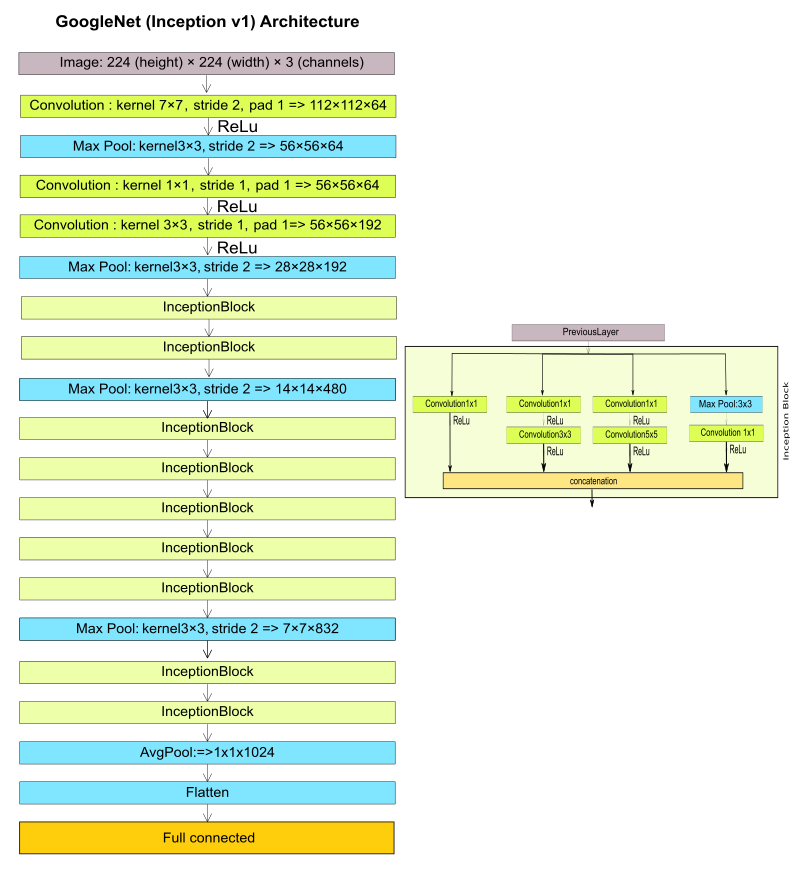

# With Pytorch

In [1]:
import torch.nn as nn
import torch
from torchsummary import summary

In [2]:
class Stem(nn.Module):
    def __init__(self):
        super(Stem , self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 3 , out_channels = 64 ,kernel_size = (7,7) , stride = (2,2) , padding = (3,3))
        self.maxPool = nn.MaxPool2d(kernel_size = (3,3), stride = (2,2), padding = 1)
        
        self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = (1,1), stride = (1,1), padding = 0)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 192, kernel_size = (3,3), stride = (1,1), padding = (1,1))
 
        self.relu = nn.ReLU(inplace = True)
    
    def forward(self , x):
        
        x = self.conv1(x)
        x = self.relu(x)

        x = self.maxPool(x)

        x = self.conv2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.relu(x)

        x = self.maxPool(x)

        return x

In [3]:
class InceptionBlock(nn.Module):
    def __init__(self, nbr_channels, out_channel_1, out_channel_2, out_channel_3, out_channel_4):
        super(InceptionBlock , self).__init__()

        self.branch1 = nn.Sequential(
                                     nn.Conv2d(in_channels = nbr_channels , out_channels = out_channel_1 , kernel_size=(1,1) , stride=(1,1)),
                                     nn.ReLU(inplace = True)
                                    )

        self.branch2 = nn.Sequential(
                                     nn.Conv2d(in_channels= nbr_channels , out_channels= out_channel_2[0] , kernel_size= (1,1), stride=(1,1)),
                                     nn.ReLU(inplace = True),
                                     nn.Conv2d(in_channels= out_channel_2[0] , out_channels= out_channel_2[1] , kernel_size= (3,3) , stride=(1,1) , padding=(1,1)),
                                     nn.ReLU(inplace = True)
                                    )

        self.branch3 = nn.Sequential(
                                     nn.Conv2d(in_channels= nbr_channels , out_channels= out_channel_3[0] , kernel_size= (1,1) , stride=(1,1)),
                                     nn.ReLU(inplace = True),
                                     nn.Conv2d(in_channels= out_channel_3[0] , out_channels= out_channel_3[1] , kernel_size= (5,5),  stride=(1,1) , padding = (2,2)),
                                     nn.ReLU(inplace = True)
                                    )

        self.branch4 = nn.Sequential(
                                     nn.MaxPool2d(kernel_size=(3,3) , stride=(1,1) , padding=(1,1)),
                                     nn.Conv2d(in_channels= nbr_channels , out_channels= out_channel_4 , kernel_size= (1,1), stride=(1,1)),
                                     nn.ReLU(inplace = True)
                                    )

    def forward(self , x):
        
        path1 = self.branch1(x)
        path2 = self.branch2(x)
        path3 = self.branch3(x)
        path4 = self.branch4(x)

        return torch.cat([path1, path2, path3, path4], 1)

In [4]:
class Inception(nn.Module):
    def __init__(self):
        super(Inception , self).__init__()
        
        self.stem = Stem()

        self.Inception1 = InceptionBlock(192, 64, (96, 128), (16, 32), 32) 
        self.Inception2 = InceptionBlock(256, 128, (128, 192), (32, 96), 64) 

        self.Inception3 = InceptionBlock(480, 192, (96, 208), (16, 48), 64) 
        self.Inception4 = InceptionBlock(512, 160, (112, 224), (24, 64), 64)     
        self.Inception5 = InceptionBlock(512, 128, (128, 256), (24, 64), 64)
        self.Inception6 = InceptionBlock(512, 112, (144, 288), (32, 64), 64)

        self.Inception7 = InceptionBlock(528, 256, (160, 320), (32, 128), 128)
        
        self.Inception8 = InceptionBlock(832, 256, (160, 320), (32, 128), 128)

        self.Inception9 = InceptionBlock(832, 384, (192, 384), (48, 128), 128)

        self.maxPool = nn.MaxPool2d(kernel_size=(3,3) , stride=(2,2) , padding=1)
        
        self.avgPool = nn.AvgPool2d(kernel_size=(7,7) , stride=(1,1))
        
        self.linear = nn.Linear(1024, 10)

    def forward(self , x):

        x = self.stem(x)

        x = self.Inception1(x)
        x = self.Inception2(x)

        x = self.maxPool(x)

        x = self.Inception3(x)
        x = self.Inception4(x)
        x = self.Inception5(x)
        x = self.Inception6(x)
        x = self.Inception7(x)

        x = self.maxPool(x)

        x = self.Inception8(x)
        x = self.Inception9(x)

        x = self.avgPool(x)
        x = torch.flatten(x, 1)
        
        x = self.linear(x)

        return x

In [5]:
dev = torch.device("cuda") 

model_1 = Inception().to(dev)
print(summary(model_1,(3,224,224)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
              ReLU-2         [-1, 64, 112, 112]               0
         MaxPool2d-3           [-1, 64, 56, 56]               0
            Conv2d-4           [-1, 64, 56, 56]           4,160
              ReLU-5           [-1, 64, 56, 56]               0
            Conv2d-6          [-1, 192, 56, 56]         110,784
              ReLU-7          [-1, 192, 56, 56]               0
         MaxPool2d-8          [-1, 192, 28, 28]               0
              Stem-9          [-1, 192, 28, 28]               0
           Conv2d-10           [-1, 64, 28, 28]          12,352
             ReLU-11           [-1, 64, 28, 28]               0
           Conv2d-12           [-1, 96, 28, 28]          18,528
             ReLU-13           [-1, 96, 28, 28]               0
           Conv2d-14          [-1, 128,

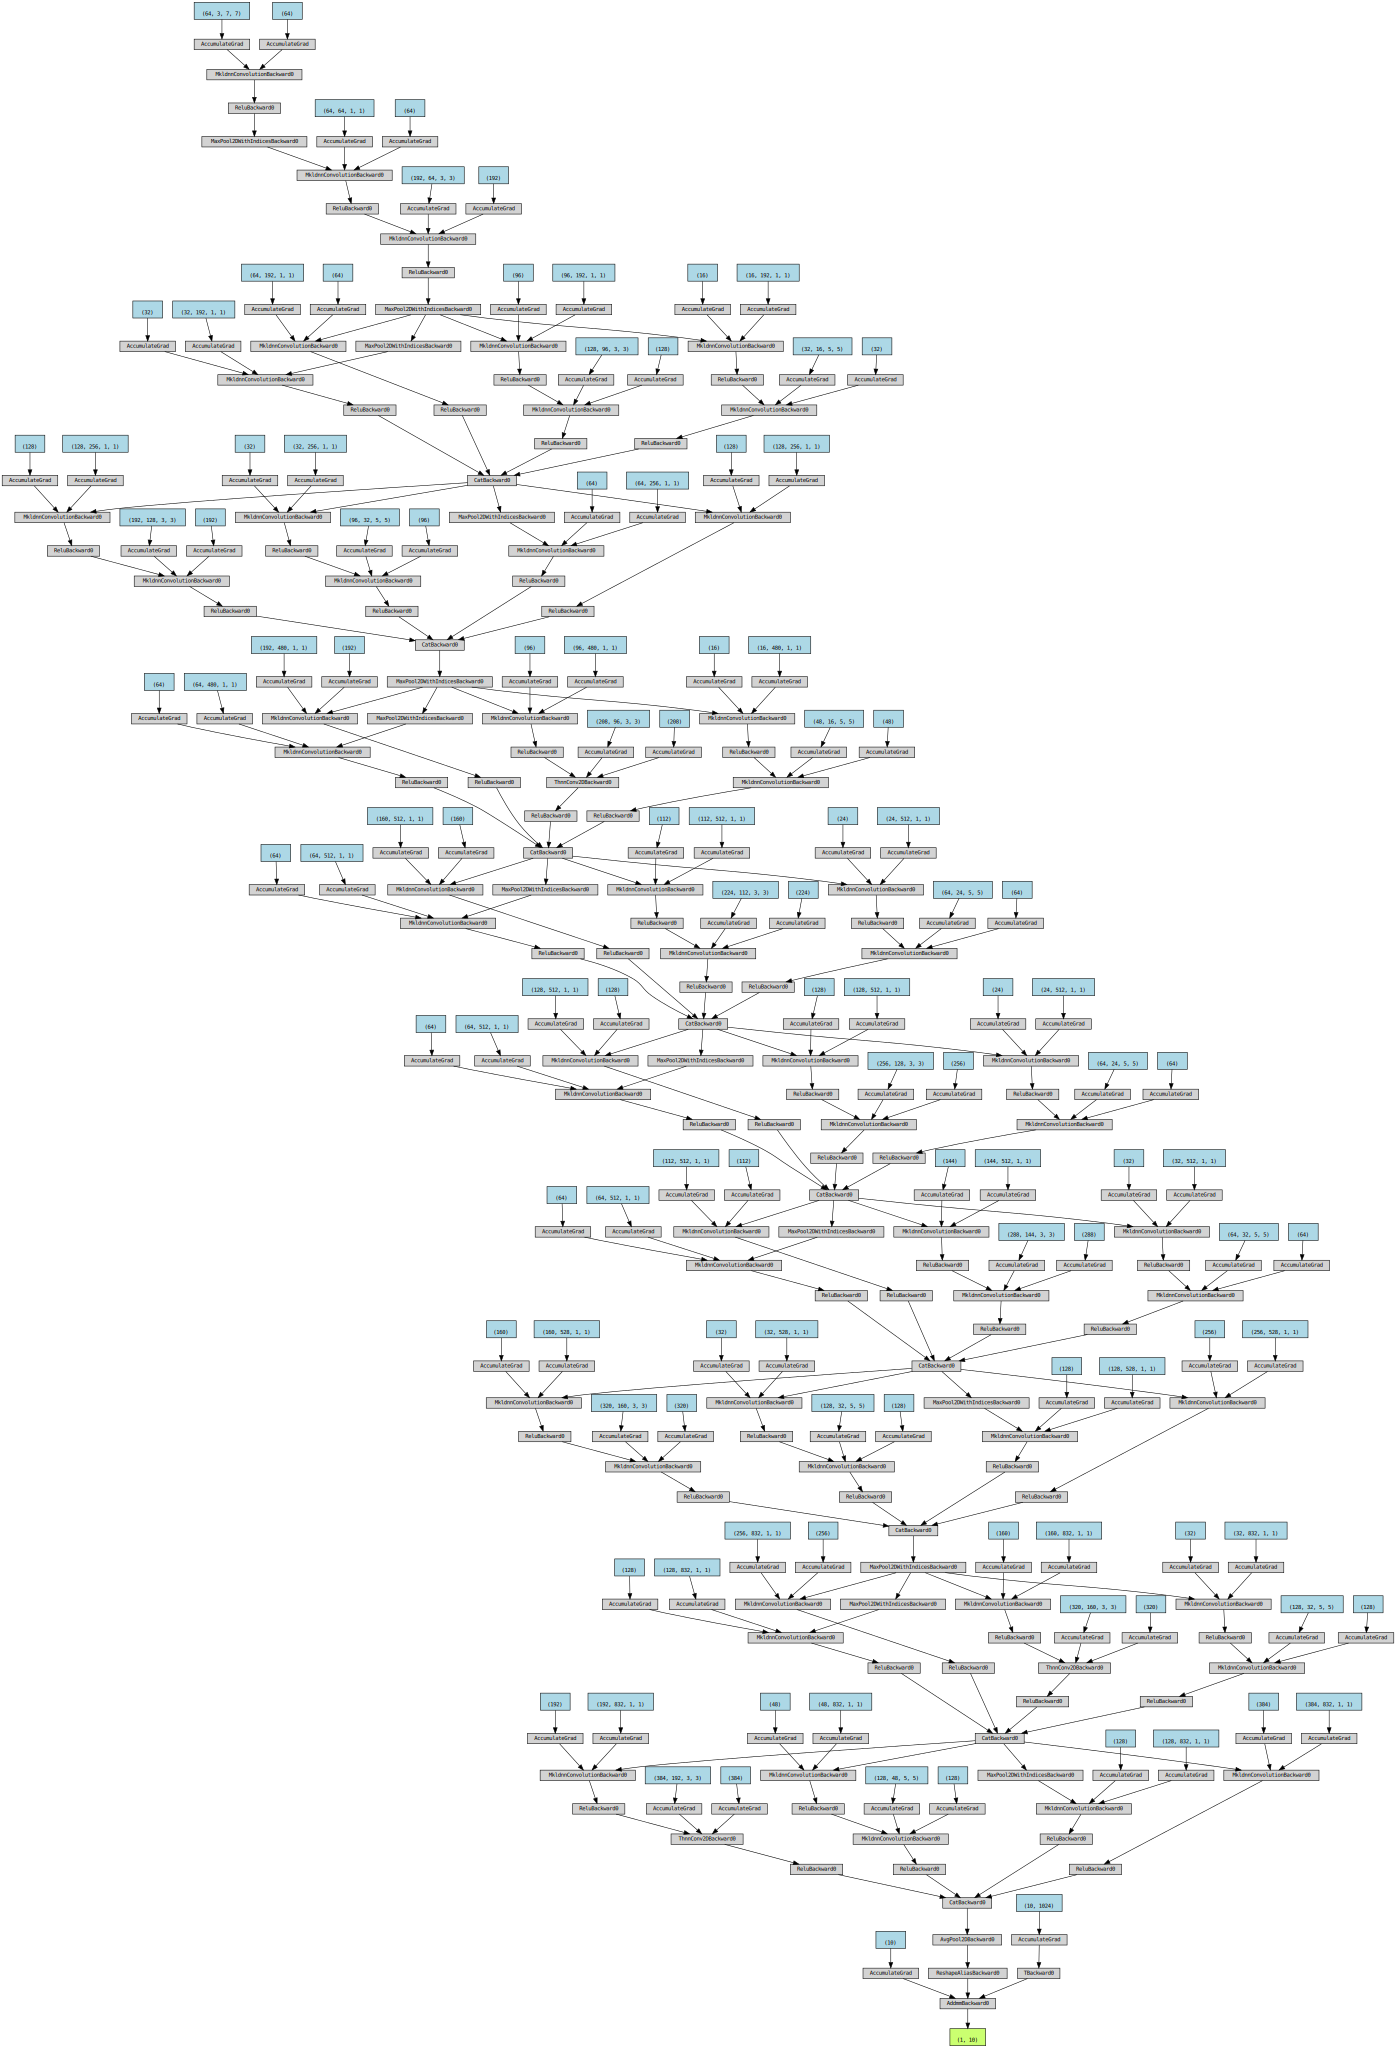

In [6]:
from torchviz import make_dot

x = torch.randn(1, 3, 224, 224)

model_1_cpu = Inception()
model_1_cpu_out = model_1_cpu(x)

#g = make_dot(out, params=None)
#g.view()
make_dot(model_1_cpu_out, params = None)

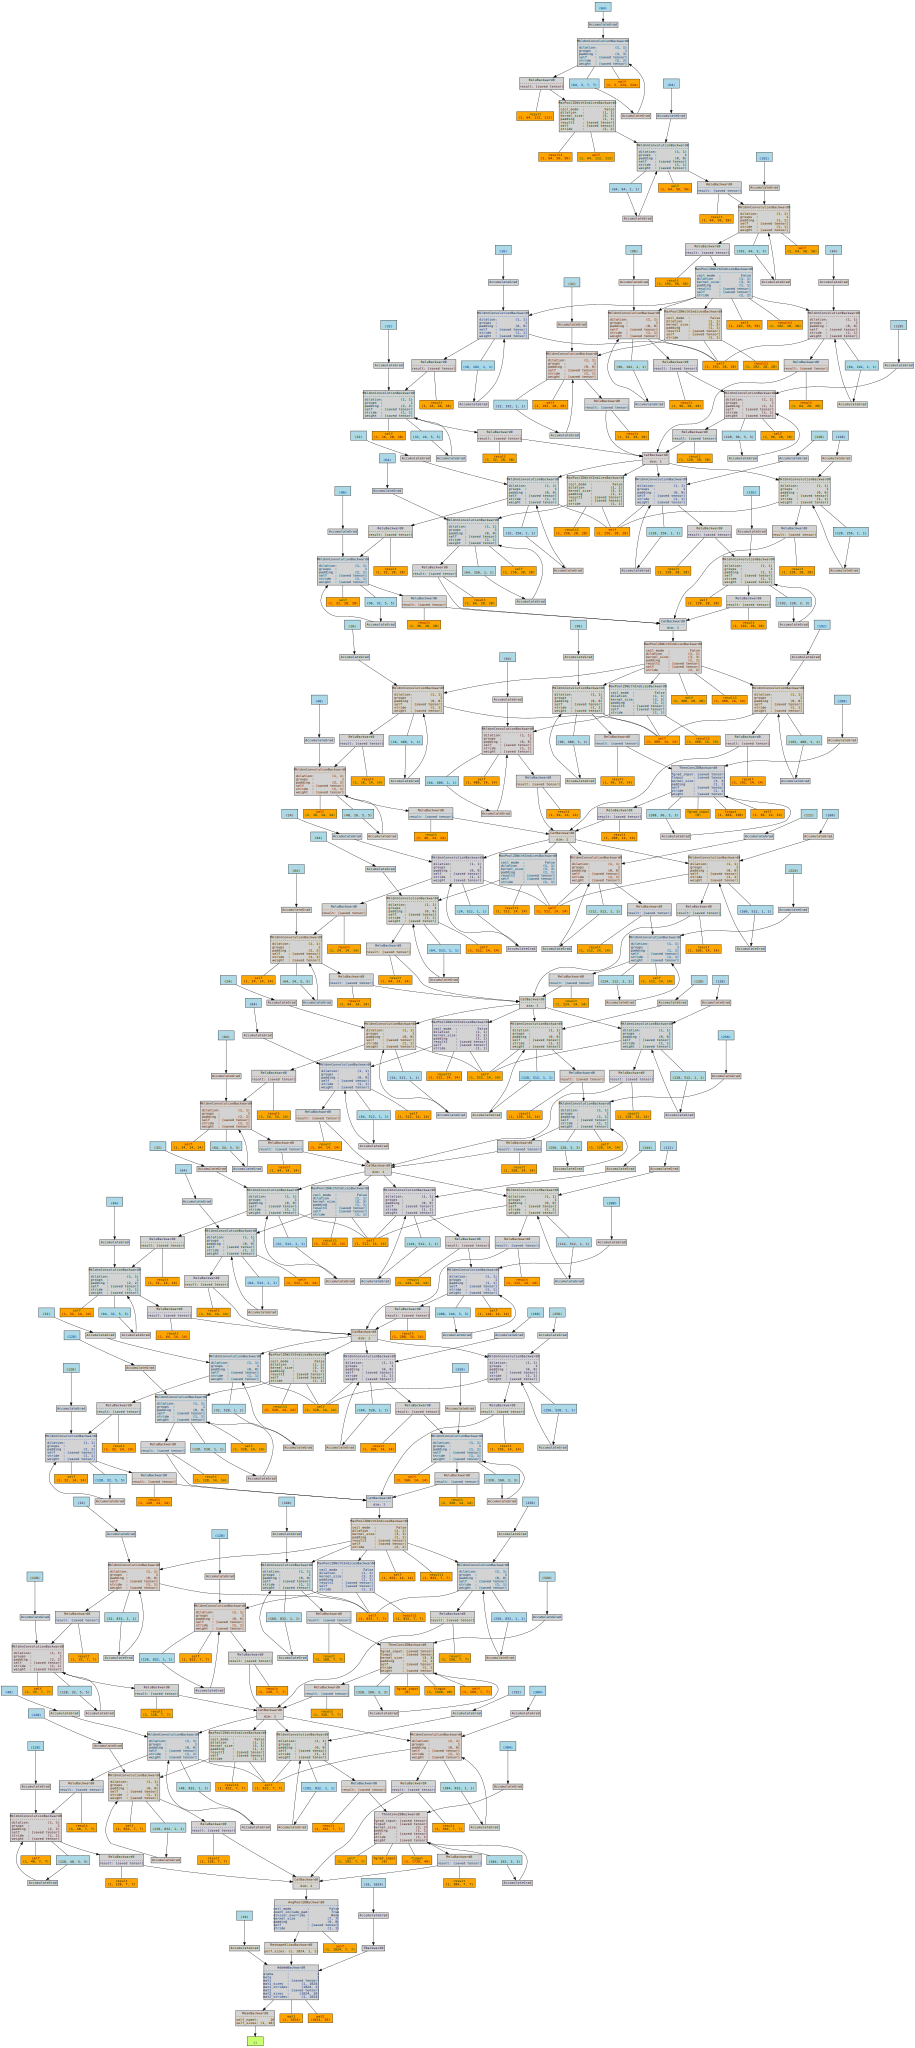

In [7]:
make_dot(model_1_cpu_out.mean(), params = None, show_attrs = True, show_saved = True)

# With Tensorflow

In [8]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Concatenate, Activation, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense

In [9]:
print(f"Tensor Flow Version: {tf.__version__}")

Tensor Flow Version: 2.6.0


# The Inception architecture builded with one subclass

In [10]:
# Here is how to build a subclass : https://www.tensorflow.org/api_docs/python/tf/keras/Model

class InceptionBlock(tf.keras.Model):
    
    def __init__(self, out_channel_1, out_channel_2, out_channel_3, out_channel_4):
        super().__init__()
        
        self.conv_1x1_path1 = Conv2D(filters = out_channel_1, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', activation='relu')
        
        self.conv_1x1_path2 = Conv2D(filters = out_channel_2[0], kernel_size = (1, 1), strides = (1, 1), padding = 'valid', activation='relu')
        self.conv_3x3_path2 = Conv2D(filters = out_channel_2[1], kernel_size = (3, 3), strides = (1, 1), padding='same', activation='relu')
        
        self.conv_1x1_path3 = Conv2D(filters = out_channel_3[0], kernel_size = (1, 1), strides = (1, 1), padding = 'valid', activation='relu')
        self.conv_5x5_path3 = Conv2D(filters = out_channel_3[1], kernel_size = (5, 5), strides = (1, 1), padding='same',activation='relu')
        
        self.MaxPool_path4 = MaxPooling2D(pool_size = (3,3), strides = (1,1), padding='same')
        self.conv_1x1_path4 = Conv2D(filters = out_channel_4, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', activation='relu')


    def call(self, inputs):
        
        path1 = self.conv_1x1_path1(inputs)
        
        path2_1 = self.conv_1x1_path2(inputs)
        path2_2 = self.conv_3x3_path2(path2_1)
        
        path3_1 = self.conv_1x1_path3(inputs)
        path3_2 = self.conv_5x5_path3(path3_1)
        
        path4_1 = self.MaxPool_path4(inputs)
        path4_2 = self.conv_1x1_path4(path4_1)
        
        return Concatenate()([path1, path2_2, path3_2, path4_2])

In [11]:
class Inception(Sequential):
    
    def __init__(self, input_shape):
        super().__init__()
        
        self.add(Conv2D(filters = 64, kernel_size = (7, 7), strides = 2, padding = 'same', activation = 'relu', input_shape = input_shape))
        self.add(MaxPooling2D(pool_size = 3, strides = 2, padding = 'same'))
        
        self.add(Conv2D(filters = 64, kernel_size = (1, 1), activation = 'relu'))
        self.add(Conv2D(filters = 192, kernel_size = (3, 3), padding = 'same', activation = 'relu'))
        self.add(MaxPooling2D(pool_size = 3, strides = 2, padding = 'same'))
        
        self.add(InceptionBlock(64, (96, 128), (16, 32), 32))
        self.add(InceptionBlock(128, (128, 192), (32, 96), 64))        
        self.add(MaxPooling2D(pool_size = 3, strides = 2, padding = 'same'))
        
        self.add(InceptionBlock(192, (96, 208), (16, 48), 64))
        self.add(InceptionBlock(160, (112, 224), (24, 64), 64))
        self.add(InceptionBlock(128, (128, 256), (24, 64), 64))
        self.add(InceptionBlock(112, (144, 288), (32, 64), 64))
        self.add(InceptionBlock(256, (160, 320), (32, 128), 128))       
        self.add(MaxPooling2D(pool_size = 3, strides = 2, padding = 'same'))
        
        self.add(InceptionBlock(256, (160, 320), (32, 128), 128))
        self.add(InceptionBlock(384, (192, 384), (48, 128), 128))        
        self.add(GlobalAveragePooling2D())
                
        self.add(Flatten())
        
        self.add(Dense(10))

In [12]:
input_layer = (224,224,3)
model_2 = Inception(input_shape = input_layer)

In [13]:
model_2.summary()

Model: "inception"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 64)      9472      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 64)        4160      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 192)       110784    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 192)       0         
_________________________________________________________________
inception_block (InceptionBl (None, 28, 28, 256)       163696    
_________________________________________________________________
inception_block_1 (Inception (None, 28, 28, 480)       38

# The Inception architecture builded with two subclass

In [14]:
# Here is how to build a subclass : https://www.tensorflow.org/api_docs/python/tf/keras/Model
# https://stackoverflow.com/questions/55109696/tensorflow-difference-between-tf-keras-layers-layer-vs-tf-keras-model

class Stem(tf.keras.Model):    
   
    def __init__(self, pool_size, out_channel_1, out_channel_2):
        super().__init__()
        
        self.MaxPool_path1 = MaxPooling2D(pool_size = pool_size, strides = (1,1), padding='same')
        self.conv_1x1_path1 = Conv2D(filters = out_channel_1, kernel_size = (1, 1), activation = 'relu')
        self.conv_3x3_path2 = Conv2D(filters = out_channel_2, kernel_size = (3, 3), padding = 'same', activation = 'relu')
        self.MaxPool_path2 = MaxPooling2D(pool_size = pool_size, strides = (1, 1), padding='same')
    
    def call(self, inputs):
        
        path1 = self.MaxPool_path1(inputs)
        path2 = self.conv_1x1_path1(path1)
        path3 = self.conv_3x3_path2(path2)    
        path4 = self.MaxPool_path2(path3)
        
        return path4

In [15]:
class InceptionBlock(tf.keras.Model):
    
    def __init__(self, out_channel_1, out_channel_2, out_channel_3, out_channel_4):
        super().__init__()
        
        self.conv_1x1_path1 = Conv2D(filters = out_channel_1, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', activation='relu')
        
        self.conv_1x1_path2 = Conv2D(filters = out_channel_2[0], kernel_size = (1, 1), strides = (1, 1), padding = 'valid', activation='relu')
        self.conv_3x3_path2 = Conv2D(filters = out_channel_2[1], kernel_size = (3, 3), strides = (1, 1), padding='same', activation='relu')
        
        self.conv_1x1_path3 = Conv2D(filters = out_channel_3[0], kernel_size = (1, 1), strides = (1, 1), padding = 'valid', activation='relu')
        self.conv_5x5_path3 = Conv2D(filters = out_channel_3[1], kernel_size = (5, 5), strides = (1, 1), padding='same',activation='relu')
        
        self.MaxPool_path4 = MaxPooling2D(pool_size = (3,3), strides = (1,1), padding='same')
        self.conv_1x1_path4 = Conv2D(filters = out_channel_4, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', activation='relu')


    def call(self, inputs):
        
        path1 = self.conv_1x1_path1(inputs)
        
        path2_1 = self.conv_1x1_path2(inputs)
        path2_2 = self.conv_3x3_path2(path2_1)
        
        path3_1 = self.conv_1x1_path3(inputs)
        path3_2 = self.conv_5x5_path3(path3_1)
        
        path4_1 = self.MaxPool_path4(inputs)
        path4_2 = self.conv_1x1_path4(path4_1)
        
        return Concatenate()([path1, path2_2, path3_2, path4_2])

In [16]:
class Inception(Sequential):
    
    def __init__(self, input_shape):
        super().__init__()
        
        self.add(Conv2D(filters = 64, kernel_size = (7, 7), strides = 2, padding = 'same', activation = 'relu', input_shape = input_shape))
        
        self.add(Stem(3, 64, 192))
        
        self.add(InceptionBlock(64, (96, 128), (16, 32), 32))
        self.add(InceptionBlock(128, (128, 192), (32, 96), 64))        
        self.add(MaxPooling2D(pool_size = 3, strides = 2, padding = 'same'))
        
        self.add(InceptionBlock(192, (96, 208), (16, 48), 64))
        self.add(InceptionBlock(160, (112, 224), (24, 64), 64))
        self.add(InceptionBlock(128, (128, 256), (24, 64), 64))
        self.add(InceptionBlock(112, (144, 288), (32, 64), 64))
        self.add(InceptionBlock(256, (160, 320), (32, 128), 128))       
        self.add(MaxPooling2D(pool_size = 3, strides = 2, padding = 'same'))
        
        self.add(InceptionBlock(256, (160, 320), (32, 128), 128))
        self.add(InceptionBlock(384, (192, 384), (48, 128), 128))        
        self.add(GlobalAveragePooling2D())
        
        self.add(Flatten())
        
        self.add(Dense(10))

In [17]:
input_layer = (224,224,3)
model_3 = Inception(input_shape = input_layer)

In [18]:
model_3.summary()

Model: "inception_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 112, 112, 64)      9472      
_________________________________________________________________
stem (Stem)                  (None, 112, 112, 192)     114944    
_________________________________________________________________
inception_block_9 (Inception (None, 112, 112, 256)     163696    
_________________________________________________________________
inception_block_10 (Inceptio (None, 112, 112, 480)     388736    
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 56, 56, 480)       0         
_________________________________________________________________
inception_block_11 (Inceptio (None, 56, 56, 512)       376176    
_________________________________________________________________
inception_block_12 (Inceptio (None, 56, 56, 512)       

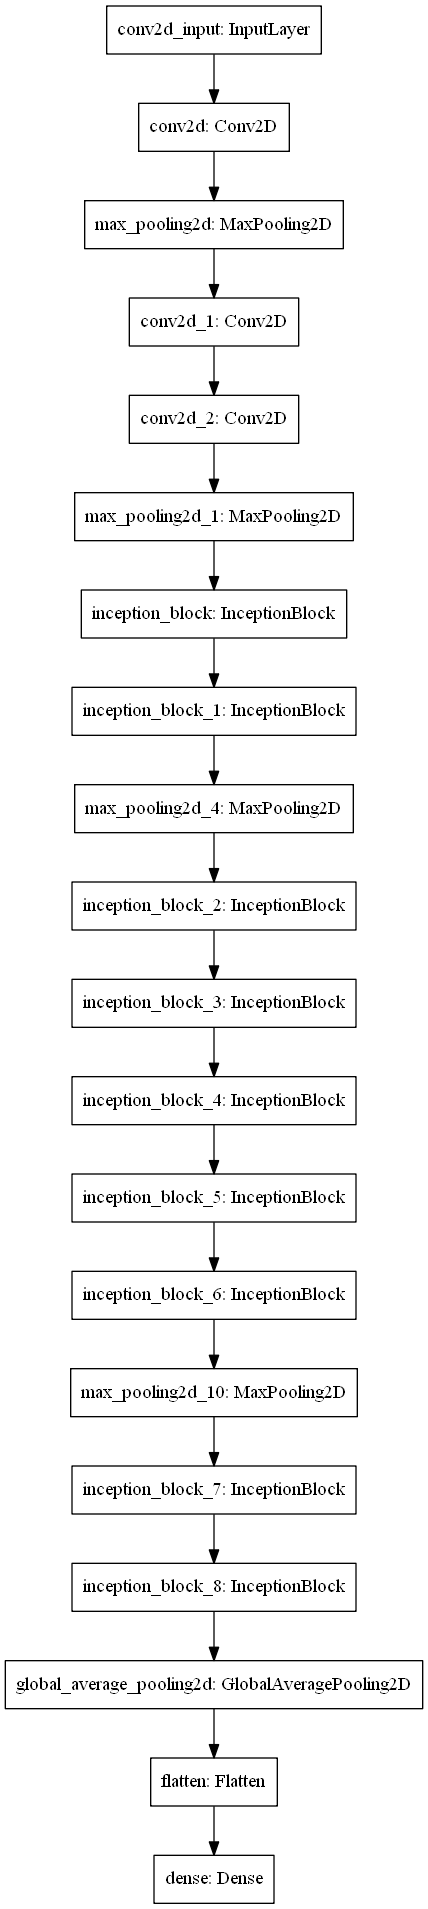

In [19]:
tf.keras.utils.plot_model(model_2)